# Traffic Sign Identification using Deep Neural Networks

## Description
Lorem Ipsum

## Setup and Image Preprocessing

### Imports

In [1]:
import cv2
import pickle
import csv
from skimage import exposure

#A tua mina, tem ganda vagina
#Mas não foste tu quem escavou bro, foi o Chico da Tina

### Preprocessing Function
Resizes and Normalizes all pictures in all of our datasets and then stores them in a dictionary.

In [2]:
def preprocess_images(file_name):
    path = './Dataset/'   # Change this for the path corresponding to your base Dataset directory

    img_infos = {'labels':[],'images':[]}

    with open(path+file_name,"r") as csv_file:
        reader = csv.reader(csv_file, delimiter=',', quotechar='|')
        next(reader)
        
        for row in reader:

            img = cv2.imread(path+row[-1], cv2.IMREAD_UNCHANGED)    
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #Convert image to Grayscale
            
            img = cv2.resize(img, (32,32),interpolation = cv2.INTER_AREA) #Resize the image to 32x32

            #img = cv2.addWeighted( img, 1.2, img, 0, 0) #Increase contrast
            
            cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX) #Normalize
            
            img_eq = exposure.equalize_adapthist(img, clip_limit=0.03)
            
            img_infos['images'].append(img_eq) #Save Image pixels
            img_infos['labels'].append(row[-2]) #Save image Label
            
    return img_infos

### Save treated data as Pickle
Srsly, funniest thing I've ever seen

In [3]:
img_infos = preprocess_images("Test.csv")
with open("./Dataset/PickledData/Test.p", 'wb') as pickle_rick:
    pickle.dump(img_infos,pickle_rick)
    
print("finished writing tests")
img_infos = preprocess_images("Train.csv")
with open("./Dataset/PickledData/Train.p", 'wb') as pickle_rick:
    pickle.dump(img_infos,pickle_rick)
print("finished writing train")


finished writing tests
finished writing train


## Neural Network

### Step 0 - Imports

In [1]:
import random
import numpy as np
import pickle

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Step 1 - Get the data into the sets

In [2]:
with open("./Dataset/PickledData/Test.p", "rb") as f:
    test = pickle.load(f)
with open("./Dataset/PickledData/Train.p", "rb") as f:
    train = pickle.load(f)

# Get the training set
x_train, y_train = train['images'], train['labels']

# Get the cross validation set
x_cv = []
y_cv = []
for i in range(int(0.2*len(x_train))): # Randomly move 20% of the training examples into the cross-validation set
    index = random.randint(0, len(x_train)-1)
    x_cv.append(x_train.pop(index))
    y_cv.append(y_train.pop(index))
    
# Get the test set
x_test, y_test = test['images'], test['labels']

# Convert all our sets into numPy Arrays
x_train = np.array(x_train).reshape((len(x_train), 32, 32, 1))
y_train = keras.utils.to_categorical(np.array(y_train))

x_cv = np.array(x_cv).reshape((len(x_cv), 32, 32, 1))
y_cv = keras.utils.to_categorical(np.array(y_cv))

x_test = np.array(x_test).reshape((len(x_test), 32, 32, 1))
y_test = keras.utils.to_categorical(np.array(y_test))

### Step 2 - Treat the data (Normalize and Shuffle)

In [3]:
# Shuffle the training set
x_train, y_train = shuffle(x_train, y_train)

### Step 3 - Define constants

In [22]:
EPOCHS = 50
BATCH_SIZE = 200
LOSS = keras.losses.categorical_crossentropy
OPT = keras.optimizers.Adam
LEARNING_RATE = 0.002 # Define the learning rate to be used by our optimizer


### Step 4 - Define the Neural Network

In [23]:
def LeNetModel(no_output=6, rgb=True, dropout=0):
    input_shape = (32,32,3) if rgb else (32,32,1) # Define the image's size
    
    model = keras.Sequential() # Define the Keras Model
    
    # First Layer - Convolutional ; Input = 32x32x3 for RGB , 32x32x1 for GrayScale ; Output = 28x28x6
    model.add(keras.layers.Conv2D(
                filters=no_output, kernel_size=(3, 3),
                activation='relu', input_shape=input_shape
                )
             )
    
    # Second Layer - Subsampling (Average Pooling) ; Input = 28x28x6 ; Output = 14x14x6
    model.add(keras.layers.AveragePooling2D())
    
    # Third Layer - Convolutional ; Input = 14x14x6 ; Output = 10x10x16
    model.add(keras.layers.Conv2D(
                    filters=16, kernel_size=(3, 3),
                    activation='relu'
                    )
                 )
    
    # Fourth Layer - Subsampling (Average Pooling) ; Input = 10x10x16 ; Output = 5x5x16
    model.add(keras.layers.AveragePooling2D())
    
    model.add(keras.layers.Flatten()) # Flatten the last layer's output to pass it to the Fully Connected layers
    
    # Fifth Layer - Fully Connected ; Input = 5x5x16 ; Output = 120x1
    model.add(keras.layers.Dense(units=120, activation='relu'))

    # Sixth Layer - Fully Connected ; Input = 120x1 ; Output = 84x1
    model.add(keras.layers.Dense(units=84, activation='relu'))
    
    model.add(keras.layers.Dropout(dropout))
    
    # Output Layer - Output = 43x1
    model.add(keras.layers.Dense(units=43, activation = 'softmax'))
    
    return model

### Step 5 - Create the model and define evaluation

In [24]:
model = LeNetModel(rgb=False, dropout=0.50)

model.compile(loss=LOSS,
              optimizer=OPT(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

### Step 6 - Insert the training set

In [25]:
history = model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=1,
          validation_data=(x_cv, y_cv))

Train on 31368 samples, validate on 7841 samples
Epoch 1/50
31368/31368 [==============================] - 3s 105us/sample - loss: 2.3795 - accuracy: 0.3457 - val_loss: 0.9822 - val_accuracy: 0.7252
Epoch 2/50
31368/31368 [==============================] - 3s 91us/sample - loss: 0.9658 - accuracy: 0.7001 - val_loss: 0.4955 - val_accuracy: 0.8545
Epoch 3/50
31368/31368 [==============================] - 3s 93us/sample - loss: 0.6254 - accuracy: 0.8052 - val_loss: 0.3438 - val_accuracy: 0.9005
Epoch 4/50
31368/31368 [==============================] - 3s 98us/sample - loss: 0.4751 - accuracy: 0.8505 - val_loss: 0.2518 - val_accuracy: 0.9241
Epoch 5/50
31368/31368 [==============================] - 3s 96us/sample - loss: 0.3933 - accuracy: 0.8758 - val_loss: 0.2231 - val_accuracy: 0.9351
Epoch 6/50
31368/31368 [==============================] - 3s 93us/sample - loss: 0.3273 - accuracy: 0.8962 - val_loss: 0.1690 - val_accuracy: 0.9523
Epoch 7/50
31368/31368 [==============================] 

In [26]:
y_predictions = model.predict_classes(x_test)

score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

12630/12630 [==============================] - 1s 91us/sample - loss: 0.3670 - accuracy: 0.9449
Test loss: 0.36699507998754505
Test accuracy: 0.9448931


### Confusion Matrix

In [18]:
#Absolute matrix
conf_mat_abs = confusion_matrix(np.argmax(y_test, axis=1), y_predictions)

#Relative matrix
conf_mat_rel = conf_mat.astype('float') / conf_mat.sum(axis=1)

### Confusion Matrix Visualized

In [ ]:
#df_cm = pd.DataFrame(conf_mat, index = [i for i in range(43)],
#                  columns = [i for i in range(43)])
#plt.figure(figsize = (100,100))

#sn.heatmap(df_cm, annot=True)

### Histogram of Accuracy per Class

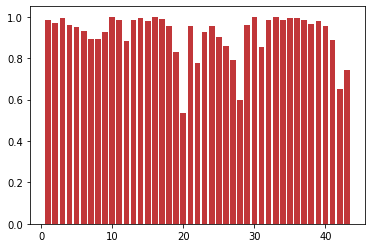

In [19]:
plt.bar(range(1,44), [conf_mat_rel[i][i] for i in range(43)])
plt.show()

## Discussion of Results


### RGB vs Grayscale

### Epoch Numbers

### Other Preprocessing Parameter changes (Contrast, lighting, etc)

### Data Augmentation
Before data augmentation we had an accuracy of 94.5% for our test accuracy

### Dropout